# Maskinlæring

I denne notebooken skal vi 

- Bruke de nyvaskede og utforskede dataene våre til å trene en eller flere maskinlæringsmodeller.

- Se på hvordan vi kan måle kvaliteten til modellene våre, og hvordan vi kan øke kvalitet. 

- Se på hvordan vi kan kontrollere hvordan modellene våre oppfører seg basert på våre egne prioriteringer.



In [14]:
import pandas as pd

Først leser vi inn dataen vår fra en fil i parquet-format til en Pandas DataFrame:

In [2]:
df = pd.read_parquet("fraud_preprocessed.pq")

Denne parquet-filen skal du ha lagret fra den andre notebooken hvor du utforsket og vasket dataene. Den skal nå være klar til bruk i maskinlæringsmodellen(e) dine.

Hvis du ønsker kan du dobbelsjekke at alt ser ut til å være på plass slik du forventer, ved å bruke noen av de følgende pandas-funksjonene:

```
df.head()  # Se de første 5 radene
df.info()  # Se datatyper og hvor mange ikke-null verdier det er for hver kolonne
df.describe()  # Se statistisk fordeling av verdier i hver kolonne
for col in df:
    print(df[col].value_counts())  # Tell hvor mange ganger hver unike verdi forekommer
    print(str(len(df[col].unique())) + " unique values in column")
    print()
```

Når man trener en maskinlæringsmodell er det god praksis å sette tilside noe data som man ikke trener på, så man kan teste på den hvor godt modellen din generaliserer.

In [16]:
from sklearn.model_selection import train_test_split

In [66]:
y_col_name = "FraudFound_P"
y = df[y_col_name]
X = df.drop(y_col_name, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Som så kan man splitte dataen én gang mellom trening og test. La oss bruke dataene til å trene en logistisk regressor, og teste den.

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logistic_regressor = LogisticRegression(solver='liblinear').fit(X_train, y_train)
y_pred = logistic_regressor.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {}%".format(round(accuracy*100, 2)))

Accuracy: 93.97%


Over 90% riktig! Pack it up, our work here is done 😎

Eller?

Hva er egentlig nøyaktighet (accuracy), og hva er en "god" nøyaktighet?

Accuracy er hvor mange prosent av klassifikasjonene dine som ble riktig. Hvis du har et binært klassifiseringsproblem slik vi har her, og fordelingen mellom de to klassene ("muffins", "Ikke muffins") i dataen din er 10/90, så vil det å alltid gjette "ikke muffins" gi deg en nøyaktighet på 90%!

Så la oss sjekke hva regressoren vår får riktig, og hva den får feil

In [92]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"Faktisk svindel:  Ja, Nei")
print(f"   predicted Ja:  {tp}, {fp}")
print(f"  predicted Nei:  {fn}, {tn}")

Faktisk svindel:  Ja, Nei
   predicted Ja:  0, 0
  predicted Nei:  307, 4782


Dette kalles en "confusion matrix". Den viser antall Type-1 og Type-2 feil, og antall riktige identifiserte tilfeller for begge klassene våre.

Som vi ser kan man få ganske høy accuracy av å aldri gjette at det er noe muffins. Så vi har ikke egentlig lært noen ting, men gjør bare et "best guess" bassert på klassebalansen.

For å oversimplifisere er accuracyen vi får her "den lavest mulige nøyaktigheten" for en maskinlæringsmodell på dette problemet.

En annen måte man måler kvaliteten til en binær klassifikasjonsmodell som denne er hvordan True Positive Rate og False Positive Rate endrer seg i forhold til hverandre ettersom man flytter grenseverdien for å si at noe lukter muffins (en positiv prediksjon) opp eller ned. Det vil si, du kan tenke at modellen egentlig lager et anslag mellom 0 og 100% på hvor sikker den er på at dette lukter muffins, og hvis du selv kan velge hvor mange prosent som skal til for at alarmen skal gå, så kan du gjøre en tradeoff mellom false positives og false negatives. I en businesscase vil man da gjøre et ansalg på langtidskostnaden av false positives versus langtidskostnaden av false negatives, og ta en runde på de etiske konsekvensene. Denne tradeoffen mellom true og false positives på forskjellige thresholds for en binær classifier kan plottes som en kurve, som vi kaller ROC-kurven (Receiver Operating Characteristic). Hvordan ser den ut i tilfellet modellen alltid gir 0% muffins som anslag?

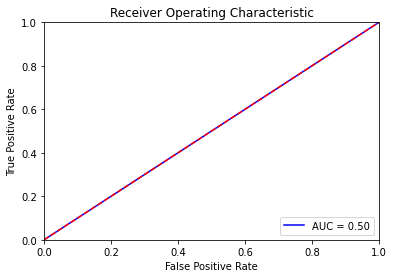

In [110]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Hvis modellen ikke har noe signal i seg finnes det ingen tradeoff å gjøre, og vi vil da få en flat ROC-kurve, og AUC = 0.50. AUC er Area Under Curve (mellom diagonalen og kurven), og 0.5 er det dårligste som går ann. Så hva har gått galt her? Vi glemte å sørge for at treningsdataen vår og testdataen vår hadde like mange muffins-tilfeller i seg. La os legge til `stratify=y` i train_test_split()-kallet vårt:

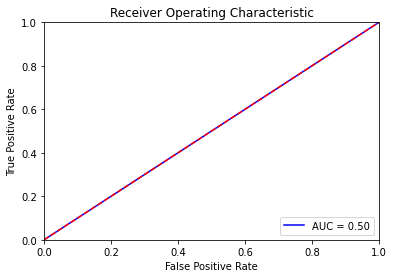

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y) 
logistic_regressor = LogisticRegression(solver='liblinear').fit(X_train, y_train)
y_pred = logistic_regressor.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Nå har vi trent og testet på én splitt, men det kan være at akkurat denne splitten forårsaker unøyaktig trening eller test på grunn av arbitrære mønstre eller støy i dataen som ikke er representative for dataen som helhet. Hvis man ønsker seg et godt mål på hvor bra treningsregimet ditt og modellen din er egnet til dataen kan det lønne seg å splitte på flere forskjellige måter, og sammenligne scorene dine fra å trene og teste på forskjellige splitter.

En metode for dette kalles K-fold cross-validation. Navnet lyder slik fordi man folder dataen i K deler, og for hver av de K delene trener man først på all dataen som ikke er i delen, og så tester man på den delen. Størrelsen på K avgjør også størrelsen på test-settene, som får størrelsen 1/K. K bør være høy nok til at treningssettet inneholder et representativt utvalg av dataen i alle tilfeller, men des høyere K er des mindre representativt for populasjonen vil testfolden være.

Ett grep som kan være viktig å ta når vi jobber med et klassifiseringsproblem er å sørge for at alle klassene er representert like tungt i alle foldene. I dette tilfellet vil det si at alle testfoldene skal ha like mange svindelforsøk, og alle treningsfoldene skal ha like mange svindelforsøk.

In [119]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
 
k = 5
k_fold_x_validation = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)  # "Stratified" betyr av vi sørger for at det er like mange svindler i hver fold

roc_auc_cv = cross_val_score(logistic_regressor, X, y, cv=k_fold_x_validation, scoring="roc_auc")
print("Avg roc_auc: {}".format(round(roc_auc_cv.mean(), 3)))
print(f"roc auc for alle folder: {roc_auc_cv}")

accuracy_cv = cross_val_score(logistic_regressor, X, y, cv=k_fold_x_validation, scoring="accuracy")
print("Avg accuracy: {}".format(round(accuracy_cv.mean(), 3)))
print(f"accuracy for alle folder: {accuracy_cv}")

Avg roc_auc: 0.794
roc auc for alle folder: [0.78937594 0.79378373 0.80365643 0.81221484 0.77065344]
Avg accuracy: 0.94
accuracy for alle folder: [0.94033722 0.94033722 0.94001297 0.94001297 0.94001297]


**Herlig!** Nå fikk vi ROC_AUC godt over 0.5, som jo betyr at det finnes informasjon i modellene våre. Kanskje vi var uheldige med splitten den første gangen? La oss generere en ROC-kurve for alle foldene våre!

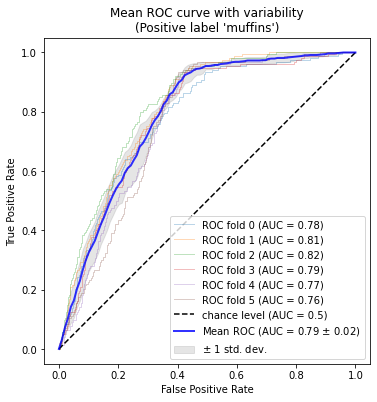

In [118]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=6)
classifier = logistic_regressor

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test],
        y.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label 'muffins')",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.show()

# Stonks 🚀📈

array([0.93514916, 0.93093385, 0.94293126, 0.94325551, 0.94844358])